# Processing of Data from 2018-06-18
## Experiment 3

In [1]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
import trackpy as tp
import pims

import support as sp

from tqdm import tqdm_notebook

from pims import pipeline
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

%matplotlib inline

idx = pd.IndexSlice

### Load File List

In [2]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment3/"
base_names = sp.get_names(directory,ext='avi')

# Repeat tracking using trackpy

### Find particles in single image to adjust parameters

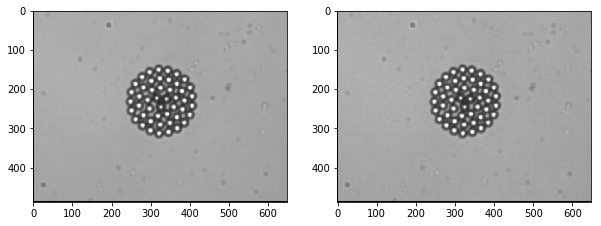

In [5]:
name = base_names[1]
video = pims.Video(name+'.avi')
NumberOfFrames=video.get_metadata()["nframes"]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(video[0])
ax2.imshow(video[1]);

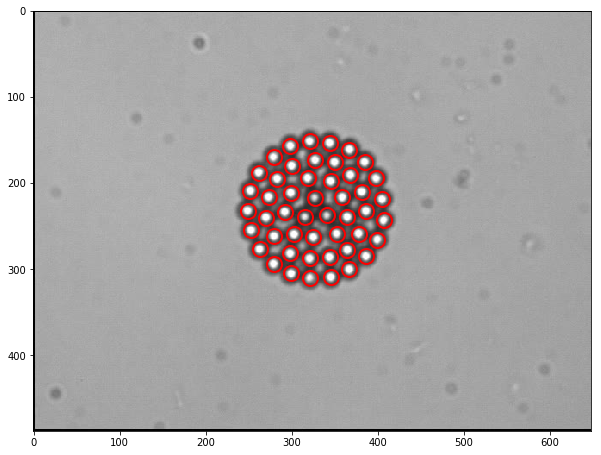

(48, 9)


In [6]:
frame = -1
f = tp.locate(as_gray(video[frame]), 19, invert=False, threshold = 7)

fig, ax = plt.subplots(1,1,figsize=(10,10))
tp.annotate(f, video[frame]);
print(np.shape(f))

### Batch

In [ ]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment3/"
base_names = sp.get_names(directory,ext='avi')

errors = []

for name in tqdm_notebook(base_names[:]):
    try:
        video = pims.Video(name+'.avi')
        print(name)
        NumberOfFrames=video.get_metadata()["nframes"]
        f = tp.batch(as_gray(video[:]), 19, invert=False, threshold = 7, characterize = False, engine='numba')
        trj = tp.link(f, 10)
        new_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy.dat'
        trj.filter(["particle","frame","x","y"]).to_csv(name+'_trackpy.dat',sep="\t")
    except Exception as e:
        number = [i for i,n in enumerate(base_names) if name==n][0]
        errors.append([number,name,e])

## Redo tracking with memory to account for lost particles

In [148]:
for name in base_names:
    trj = pd.read_csv(name+"_trackpy.dat",sep="\t")
    find = trj.filter(["frame","x","y"])
    trj = tp.link(find, 10, memory = 5)

    trj = trj.set_index(["frame","particle"]).filter(["x","y"])
    trj_len = trj.groupby("particle").count()
    trj = trj.loc[idx[:,trj_len[trj_len["x"]>1000].index],:]
    
    new_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy_mem.dat'
    trj.to_csv(new_name,sep="\t")

Frame 17999: 48 trajectories present.


# Process a single trajectory
 
A single trajectory is processed by the following protocol.

* read from csv the array created by trackpy, which is indexed by `frame` and `particle`
* from px to um,
* from `frame` index to `time` index obtained from the LabVIEW tracking. Change name from `particle` to `id`
* add layer number to each particle in the trajectory
* recenter the array using a circle fitted to the outermost layer. 
* add the field values from the field log. 
* save file as hdf5

In [206]:
name = base_names[1]

In [207]:
def new_name(name):
    return os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy_mem.dat'

In [208]:
trj = pd.read_csv(new_name(name),sep="\t",index_col=["frame","particle"])

In [209]:
def from_frame_to_real_time(trj,name):
    """ Asigns labview timestamp to the frames of trj"""
    trj_real_time = pd.read_csv(name+'.dat',sep="\t",header=None)
    time = pd.to_datetime(trj_real_time[0].values+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))

    trj["time"] = time[trj.index.get_level_values("frame")]
    trj["id"] = trj.index.get_level_values("particle")
    trj = trj.set_index(["time","id"])
    return trj
    
trj = from_frame_to_real_time(trj,name)

In [210]:
def from_px_to_um(trj,px_size):
    trj.x = trj.x*px_size # microns per pixel
    trj.y = trj.y*px_size # microns per pixel
    return trj

trj = from_px_to_um(trj,0.1805)

In [211]:
def add_layers(trj):
    time = trj.index.get_level_values("time").unique()
    layer_indexes = sp.layers(trj.loc[sp.idx[time[round(len(time)/2)],:],:])
    
    for i,l in enumerate(layer_indexes):
        trj.loc[sp.idx[:,layer_indexes[i]],"layer"] = i
        
    return trj

trj = add_layers(trj)

In [212]:
def recenter(trj):
    center = sp.get_center(trj[trj.layer==0])
    trj.x+=-center[0]
    trj.y+=-center[1]
    return trj

trj = recenter(trj)

In [213]:
field_filename = "Z:/LargeData/2018-06-18-Data/Field-2018-06-18.log"

field= pd.read_csv(field_filename,delim_whitespace=True)
field["time"] = pd.to_datetime(field["Time(s)"]+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
field = field.set_index("time").filter(["X_Amplitude"])
    
def field_values(trj,field):

    time = trj.index.get_level_values("time").unique()
    
    field_re = field.reindex(field.index.append(time).sort_values(),method = "pad")
    field_re = field_re[~field_re.index.duplicated(keep='first')]
    field_re = field_re.loc[trj.index.get_level_values("time")[:]].X_Amplitude
    
    trj["field"] = field_re.values
    return trj

trj = field_values(trj,field)

In [214]:
trj = sp.calculate_polar(trj)
trj = sp.calculate_velocities(trj)

In [215]:
omegas = trj.groupby(["field","layer"]).mean().filter(["omega"])

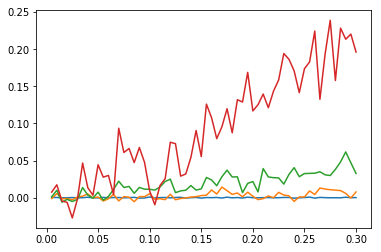

In [216]:
for l in omegas.index.get_level_values("layer").unique():
    o = omegas.loc[idx[:,l],:]
    plt.plot((o.index.get_level_values("field")*1.5)**2,-o.omega)

## Batch Process

In [223]:
for experiment,name in tqdm_notebook(enumerate(base_names[152:])):
    trj = pd.read_csv(new_name(name),sep="\t",index_col=["frame","particle"])
    trj = from_frame_to_real_time(trj,name)
    trj = from_px_to_um(trj,0.1805)
    trj = add_layers(trj)
    trj = recenter(trj)
    trj = field_values(trj,field)
    
    hdf_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_field_layer.hd5'
    
    with pd.HDFStore(hdf_name) as hdf_trj:
        hdf_trj.put('trj',trj,format='t')

A Jupyter Widget

base_names 95 and 151 are troublesome. For the moment they are ignored.

## Calculate the angular velocities of every trajectory and store it in the hdf5.

In [2]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment3/"
base_names = sp.get_names(directory,ext='hd5')

In [38]:
for experiment,name in tqdm_notebook(enumerate(base_names)):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        trj = hdf_trj.select("trj")

        trj = sp.calculate_polar(trj)
        trj = sp.calculate_velocities(trj)

        omegas = trj.groupby(["field","layer"]).mean().filter(["omega"])
        omegas["experiment"] = experiment

        if trj.groupby('field').mean().sort_index().rel_time.diff().mean()>0:
            omegas["direction"] = "forward"
        else:
            omegas["direction"] = "backward"
            
        hdf_trj.put("omegas",omegas,format='t')

A Jupyter Widget

## Merge angular velocities into a single pandas DataFrame. Plot.

In [3]:
def load_omegas(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        return hdf_trj.select('omegas')
results = pd.concat([load_omegas(name) for name in tqdm_notebook(base_names)])

A Jupyter Widget

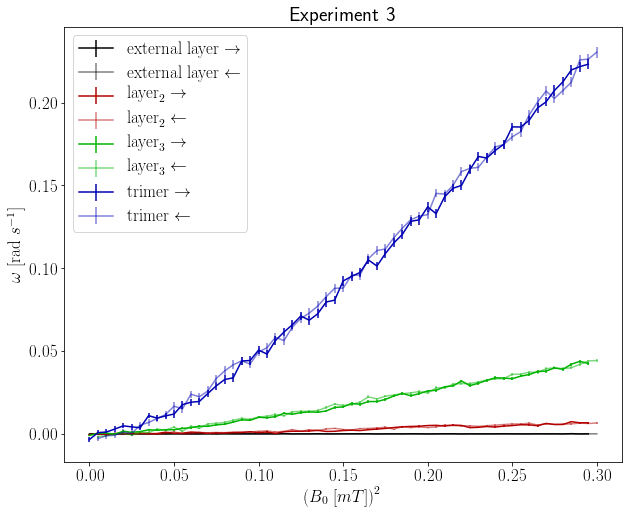

In [5]:
results_stat = results.groupby(["direction","field","layer"]).mean().filter(["omega"])
results_stat['error'] = results.groupby(["direction","field","layer"]).std().filter(["omega"])/\
                            np.sqrt(results.groupby(["direction","field","layer"]).count().filter(["omega"]))
results_stat.head()

fig, ax = plt.subplots(1,1,figsize=[10,8])

colors = [[0,0,0],[0.7,0,0],[0,0.7,0],[0,0,0.7]]

for i in np.arange(4):

    plt.errorbar(
        (results_stat.loc[sp.idx["forward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["forward",:,i],:].omega,
        results_stat.loc[sp.idx["forward",:,i],:].error,
        color=colors[i])
    plt.errorbar(
        (results_stat.loc[sp.idx["backward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["backward",:,i],:].omega,
        results_stat.loc[sp.idx["backward",:,i],:].error,
        color=colors[i],alpha=0.5)


font_size = 17
plt.rc('text', usetex=True)
plt.rc('font', size=font_size)

plt.title("Experiment 3")
    
plt.ylabel(r"$\omega\ [\textrm{rad}\ s^{-1}]$",fontsize=font_size)
plt.xlabel(r"$\left(B_0\ [mT]\right)^2$",fontsize=font_size)

plt.legend((
    r'$\textrm{external layer} \rightarrow$',
    r'$\textrm{external layer} \leftarrow$',
    r'$\textrm{layer}_2 \rightarrow$',
    r'$\textrm{layer}_2 \leftarrow$',
    r'$\textrm{layer}_3 \rightarrow$',
    r'$\textrm{layer}_3 \leftarrow$',
    r'$\textrm{trimer} \rightarrow$',
    r'$\textrm{trimer} \leftarrow$'),fontsize=font_size)